# Predicting COVID-19 in European Countries with Random Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
from pandas.plotting import lag_plot
from matplotlib import pyplot as plt
from matplotlib.dates import date2num
%matplotlib inline
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
import json
plt.close("all")

euro_data = pd.read_csv("data/euro_countries_padded.csv")
with open("data/iso_country_codes.json", "r") as read_file:
    country_codes = json.load(read_file)

euro_data.head(5)


Bad key savefig.frameon in file /home/alpakkan/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/alpakkan/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/alpakkan/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an upd

,Unnamed: 0,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,population,total_tests,new_tests,new_tests_smoothed
0,0,ALB,Albania,2019-12-31,0.0,0.0,0.0,2877800.0,0.0,0.0,0.0
1,1,ALB,Albania,2020-01-01,0.0,0.0,0.0,2877800.0,0.0,0.0,0.0
2,2,ALB,Albania,2020-01-02,0.0,0.0,0.0,2877800.0,0.0,0.0,0.0
3,3,ALB,Albania,2020-01-03,0.0,0.0,0.0,2877800.0,0.0,0.0,0.0
4,4,ALB,Albania,2020-01-04,0.0,0.0,0.0,2877800.0,0.0,0.0,0.0


In [2]:
countries = ['NOR', 'ESP', 'DEU']

nor_df = euro_data[euro_data.iso_code=='NOR'].groupby('date')['new_cases_smoothed', 'total_tests', 'new_tests', 'population'].sum().reset_index()
esp_df = euro_data[euro_data.iso_code=='ESP'].groupby('date')['new_cases_smoothed', 'total_tests', 'new_tests', 'population'].sum().reset_index()
deu_df = euro_data[euro_data.iso_code=='DEU'].groupby('date')['new_cases_smoothed', 'total_tests', 'new_tests', 'population'].sum().reset_index()

dfs = [nor_df, esp_df, deu_df]

nor_df

/home/alpakkan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/alpakkan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
/home/alpakkan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,date,new_cases_smoothed,total_tests,new_tests,population
0,2019-12-31,0.000,0.0,0.0,5421242.0
1,2020-01-01,0.000,0.0,0.0,5421242.0
2,2020-01-02,0.000,0.0,0.0,5421242.0
3,2020-01-03,0.000,0.0,0.0,5421242.0
4,2020-01-04,0.000,0.0,0.0,5421242.0
...,...,...,...,...,...
311,2020-11-06,501.286,0.0,0.0,5421242.0
312,2020-11-07,523.143,0.0,0.0,5421242.0
313,2020-11-08,523.143,0.0,0.0,5421242.0
314,2020-11-09,523.143,0.0,0.0,5421242.0


In [3]:
start_date, end_date = '2020-03-01', '2020-11-07'

def preprocess_dfs(dfs):
    preprocessed = []
    for df in dfs:
        start_index = list(np.where(df['date'] == start_date)[0])[0]
        end_index = list(np.where(df['date'] == end_date)[0])[0]
        df = df[start_index:end_index + 1]

        df.date = pd.to_datetime(df.date)

        df['day'] = df['date'].dt.day
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
        df['weekday'] = df['date'].dt.strftime('%A')
        preprocessed.append(df)
    return preprocessed

dfs = preprocess_dfs(dfs)
nor_df = dfs[0]
esp_df = dfs[1]
deu_df = dfs[2]

nor_df

/home/alpakkan/.local/lib/python3.6/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/alpakkan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/alpakkan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


,date,new_cases_smoothed,total_tests,new_tests,population,day,month,year,weekday
61,2020-03-01,2.143,1205.0,235.0,5421242.0,1,3,2020,Sunday
62,2020-03-02,2.714,1596.0,391.0,5421242.0,2,3,2020,Monday
63,2020-03-03,3.571,1976.0,380.0,5421242.0,3,3,2020,Tuesday
64,2020-03-04,4.714,2317.0,341.0,5421242.0,4,3,2020,Wednesday
65,2020-03-05,7.857,2691.0,374.0,5421242.0,5,3,2020,Thursday
...,...,...,...,...,...,...,...,...,...
308,2020-11-03,389.429,1762585.0,26134.0,5421242.0,3,11,2020,Tuesday
309,2020-11-04,427.571,1782611.0,20026.0,5421242.0,4,11,2020,Wednesday
310,2020-11-05,470.143,0.0,0.0,5421242.0,5,11,2020,Thursday
311,2020-11-06,501.286,0.0,0.0,5421242.0,6,11,2020,Friday


## Exploratory Data Analysis

Text(0.5, 1.0, 'Germany')

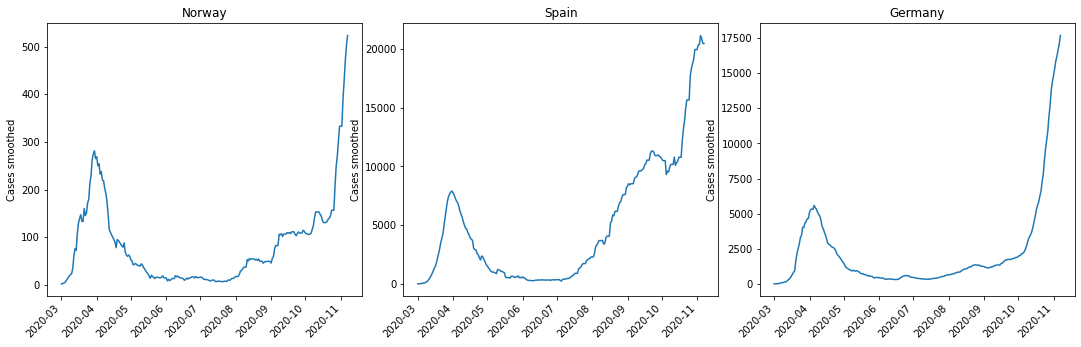

In [4]:
dates = nor_df['date']

f1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
f1.tight_layout()
f1.autofmt_xdate(rotation = 45)
ax1.plot(dates, nor_df['new_cases_smoothed'])
ax1.set_xlabel(''); ax1.set_ylabel('Cases smoothed'); ax1.set_title('Norway')
ax2.plot(dates, esp_df['new_cases_smoothed'])
ax2.set_xlabel(''); ax2.set_ylabel('Cases smoothed'); ax2.set_title('Spain')
ax3.plot(dates, deu_df['new_cases_smoothed'])
ax3.set_xlabel(''); ax3.set_ylabel('Cases smoothed'); ax3.set_title('Germany')

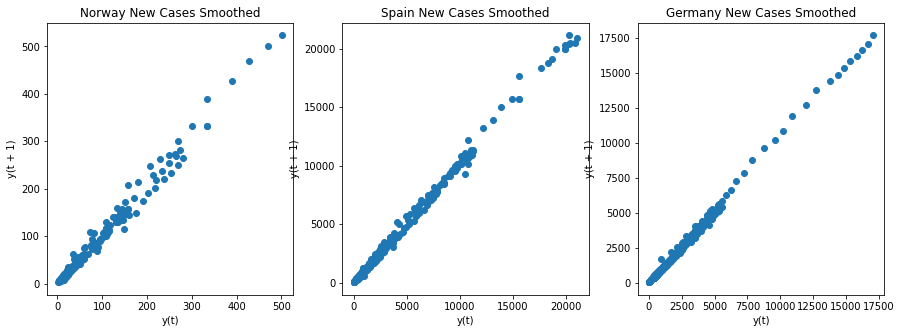

In [5]:
# Make lag plot
f2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
lag_plot(nor_df['new_cases_smoothed'], ax=ax1)
lag_plot(esp_df['new_cases_smoothed'], ax=ax2)
lag_plot(deu_df['new_cases_smoothed'], ax=ax3)
ax1.set_title('Norway New Cases Smoothed');
ax2.set_title('Spain New Cases Smoothed');
ax3.set_title('Germany New Cases Smoothed');

## Detrend the Time Series

### Try Differencing

/home/alpakkan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Germany Differenced New Cases')

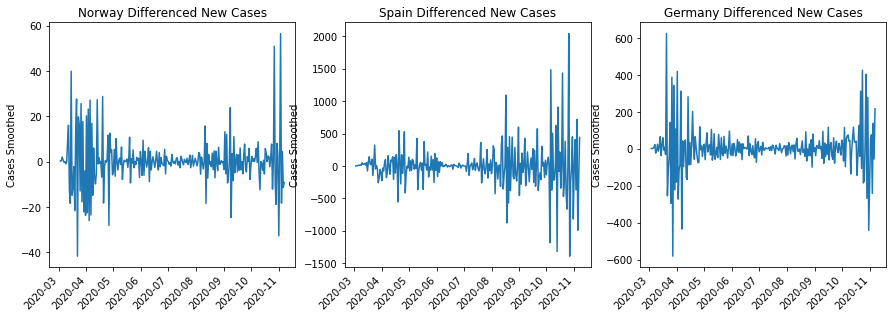

In [6]:
nor_df['new_cases_diff'] = nor_df['new_cases_smoothed'].diff(periods=1).diff(periods=1)
esp_df['new_cases_diff'] = esp_df['new_cases_smoothed'].diff(periods=1).diff(periods=1)
deu_df['new_cases_diff'] = deu_df['new_cases_smoothed'].diff(periods=1).diff(periods=1)

f6, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
f6.autofmt_xdate(rotation = 45)
ax1.plot(dates, nor_df['new_cases_diff'])
ax1.set_xlabel(''); ax1.set_ylabel('Cases Smoothed'); ax1.set_title('Norway Differenced New Cases')
ax2.plot(dates, esp_df['new_cases_diff'])
ax2.set_xlabel(''); ax2.set_ylabel('Cases Smoothed'); ax2.set_title('Spain Differenced New Cases')
ax3.plot(dates, deu_df['new_cases_diff'])
ax3.set_xlabel(''); ax3.set_ylabel('Cases Smoothed'); ax3.set_title('Germany Differenced New Cases')

## Check for Missing Values

In [7]:
# Relative frequency of missing values for each column
for df in dfs:
    print('*******')
    print(df.isnull().sum()/(len(df))*100)

*******
date                  0.000000
new_cases_smoothed    0.000000
total_tests           0.000000
new_tests             0.000000
population            0.000000
day                   0.000000
month                 0.000000
year                  0.000000
weekday               0.000000
new_cases_diff        0.793651
dtype: float64
*******
date                  0.000000
new_cases_smoothed    0.000000
total_tests           0.000000
new_tests             0.000000
population            0.000000
day                   0.000000
month                 0.000000
year                  0.000000
weekday               0.000000
new_cases_diff        0.793651
dtype: float64
*******
date                  0.000000
new_cases_smoothed    0.000000
total_tests           0.000000
new_tests             0.000000
population            0.000000
day                   0.000000
month                 0.000000
year                  0.000000
weekday               0.000000
new_cases_diff        0.793651
dtype: float64


## Feature Engineering

In [8]:
# Remove date column
nor_features = nor_df.drop('date', axis = 1)
esp_features = esp_df.drop('date', axis = 1)
deu_features = deu_df.drop('date', axis = 1)

features = [nor_features, esp_features, deu_features]

# Create lags
lag = 3

def build_lagged_features(s,lag=3,dropna=True):
    if type(s) is pd.DataFrame:
        new_dict={}
        for col_name in s:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l*7)]=s[col_name].shift(l*7)
        res=pd.DataFrame(new_dict,index=s.index)
    if dropna:
        return res.dropna()
    else:
        return res

def build_all(features):
    new_features = []
    for f in features:
        lagged = build_lagged_features(f.drop(['day', 'month', 'year', 'weekday', 'population'], axis = 1), lag=lag)
        lagged['day'] = f['day'][lag:]
        lagged['month'] = f['month'][lag:]
        lagged['year'] = f['year'][lag:]
        lagged['weekday'] = f['weekday'][lag:]
        lagged['population'] = f['population'][lag:]
        lagged = lagged.drop(['total_tests', 'new_tests', 'new_cases_diff'], axis = 1)
        # One-hot encode weekdays
        lagged = pd.get_dummies(lagged)
        new_features.append(lagged)
    return new_features

lagged_features = build_all(features)
nor_features = lagged_features[0]
esp_features = lagged_features[1]
deu_features = lagged_features[2]

nor_features

,new_cases_smoothed,new_cases_smoothed_lag7,new_cases_smoothed_lag14,new_cases_smoothed_lag21,total_tests_lag7,total_tests_lag14,total_tests_lag21,new_tests_lag7,new_tests_lag14,new_tests_lag21,...,month,year,population,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
84,171.714,139.571,23.857,3.571,34585.0,6949.0,1976.0,6586.0,1686.0,380.0,...,3,2020,5421242.0,0,0,0,0,0,1,0
85,179.714,147.286,34.857,4.714,41412.0,9034.0,2317.0,6827.0,2085.0,341.0,...,3,2020,5421242.0,0,0,0,0,0,0,1
86,213.286,133.429,61.857,7.857,47395.0,12051.0,2691.0,5983.0,3017.0,374.0,...,3,2020,5421242.0,0,0,0,0,1,0,0
87,229.143,133.000,76.429,11.714,52514.0,16105.0,3056.0,5119.0,4054.0,365.0,...,3,2020,5421242.0,1,0,0,0,0,0,0
88,262.714,160.143,72.571,15.286,55021.0,18866.0,3371.0,2507.0,2761.0,315.0,...,3,2020,5421242.0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,389.429,207.429,133.143,152.429,1627059.0,1520644.0,1429242.0,20935.0,16874.0,15698.0,...,11,2020,5421242.0,0,0,0,0,0,1,0
309,427.571,248.286,137.714,147.857,1648247.0,1536747.0,1444385.0,21188.0,16103.0,15143.0,...,11,2020,5421242.0,0,0,0,0,0,0,1
310,470.143,270.286,140.000,143.857,1669196.0,1552224.0,1458080.0,20949.0,15477.0,13695.0,...,11,2020,5421242.0,0,0,0,0,1,0,0
311,501.286,300.286,144.429,134.429,1689586.0,1567487.0,1471043.0,20390.0,15263.0,12963.0,...,11,2020,5421242.0,1,0,0,0,0,0,0


## Training

In [9]:
# Splitting into labels and features
nor_labels = nor_features['new_cases_smoothed']
nor_features = nor_features.drop('new_cases_smoothed', axis = 1)
esp_labels = esp_features['new_cases_smoothed']
esp_features = esp_features.drop('new_cases_smoothed', axis = 1)
deu_labels = deu_features['new_cases_smoothed']
deu_features = deu_features.drop('new_cases_smoothed', axis = 1)

feature_list = list(nor_features.columns)

In [10]:
# Splitting into training and testing sets
#train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 49)
# Using first 7 days of November as testing set
nor_train_features = nor_features[:-7]
nor_test_features = nor_features[-7:]
nor_train_labels = nor_labels[:-7]
nor_test_labels = nor_labels[-7:]

esp_train_features = esp_features[:-7]
esp_test_features = esp_features[-7:]
esp_train_labels = esp_labels[:-7]
esp_test_labels = esp_labels[-7:]

deu_train_features = deu_features[:-7]
deu_test_features = deu_features[-7:]
deu_train_labels = deu_labels[:-7]
deu_test_labels = deu_labels[-7:]

nor_test_features

,new_cases_smoothed_lag7,new_cases_smoothed_lag14,new_cases_smoothed_lag21,total_tests_lag7,total_tests_lag14,total_tests_lag21,new_tests_lag7,new_tests_lag14,new_tests_lag21,new_cases_diff_lag7,...,month,year,population,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
306,156.571,130.714,153.143,1582737.0,1483299.0,1393928.0,7757.0,6371.0,6420.0,-12.142,...,11,2020,5421242.0,0,0,0,1,0,0,0
307,156.571,130.714,153.143,1606124.0,1503770.0,1413544.0,23387.0,20471.0,19616.0,0.000,...,11,2020,5421242.0,0,1,0,0,0,0,0
308,207.429,133.143,152.429,1627059.0,1520644.0,1429242.0,20935.0,16874.0,15698.0,50.858,...,11,2020,5421242.0,0,0,0,0,0,1,0
309,248.286,137.714,147.857,1648247.0,1536747.0,1444385.0,21188.0,16103.0,15143.0,-10.001,...,11,2020,5421242.0,0,0,0,0,0,0,1
310,270.286,140.000,143.857,1669196.0,1552224.0,1458080.0,20949.0,15477.0,13695.0,-18.857,...,11,2020,5421242.0,0,0,0,0,1,0,0
311,300.286,144.429,134.429,1689586.0,1567487.0,1471043.0,20390.0,15263.0,12963.0,8.000,...,11,2020,5421242.0,1,0,0,0,0,0,0
312,333.000,156.571,130.714,1699142.0,1574980.0,1476928.0,9556.0,7493.0,5885.0,2.714,...,11,2020,5421242.0,0,0,1,0,0,0,0


In [11]:
# Convert to numpy array
nor_train_features = np.array(nor_train_features)
nor_train_labels = np.array(nor_train_labels)
nor_test_features = np.array(nor_test_features)
nor_test_labels = np.array(nor_test_labels)

esp_train_features = np.array(esp_train_features)
esp_train_labels = np.array(esp_train_labels)
esp_test_features = np.array(esp_test_features)
esp_test_labels = np.array(esp_test_labels)

deu_train_features = np.array(deu_train_features)
deu_train_labels = np.array(deu_train_labels)
deu_test_features = np.array(deu_test_features)
deu_test_labels = np.array(deu_test_labels)

In [12]:
# Train random forest model with 1000 decision trees
nor_rf = RandomForestRegressor(n_estimators = 1000, random_state = 49)
nor_rf.fit(nor_train_features, nor_train_labels)

esp_rf = RandomForestRegressor(n_estimators = 1000, random_state = 49)
esp_rf.fit(esp_train_features, esp_train_labels)

deu_rf = RandomForestRegressor(n_estimators = 1000, random_state = 49)
deu_rf.fit(deu_train_features, deu_train_labels)

RandomForestRegressor(n_estimators=1000, random_state=49)

In [13]:
nor_predictions = nor_rf.predict(nor_test_features)
esp_predictions = esp_rf.predict(esp_test_features)
deu_predictions = deu_rf.predict(deu_test_features)

In [14]:
# Get Mean Absolute Error (MAE)
nor_errors = abs(nor_predictions - nor_test_labels)
esp_errors = abs(esp_predictions - esp_test_labels)
deu_errors = abs(deu_predictions - deu_test_labels)
print('MAE:', round(np.mean(nor_errors), 2), 'new cases')
print('MAE:', round(np.mean(esp_errors), 2), 'new cases')
print('MAE:', round(np.mean(deu_errors), 2), 'new cases')

MAE: 177.35 new cases
MAE: 2280.15 new cases
MAE: 5795.08 new cases


In [15]:
# Get feature importances
importances = list(nor_rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort feature importances descendingly by importance
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: new_cases_smoothed_lag7 Importance: 0.74
Variable: total_tests_lag7     Importance: 0.07
Variable: total_tests_lag14    Importance: 0.07
Variable: total_tests_lag21    Importance: 0.07
Variable: day                  Importance: 0.03
Variable: new_tests_lag7       Importance: 0.01
Variable: new_cases_smoothed_lag14 Importance: 0.0
Variable: new_cases_smoothed_lag21 Importance: 0.0
Variable: new_tests_lag14      Importance: 0.0
Variable: new_tests_lag21      Importance: 0.0
Variable: new_cases_diff_lag7  Importance: 0.0
Variable: new_cases_diff_lag14 Importance: 0.0
Variable: new_cases_diff_lag21 Importance: 0.0
Variable: month                Importance: 0.0
Variable: year                 Importance: 0.0
Variable: population           Importance: 0.0
Variable: weekday_Friday       Importance: 0.0
Variable: weekday_Monday       Importance: 0.0
Variable: weekday_Saturday     Importance: 0.0
Variable: weekday_Sunday       Importance: 0.0
Variable: weekday_Thursday     Importance: 

## Export results

In [16]:
d = {'rf_nor': nor_predictions, 'rf_esp': esp_predictions, 'rf_deu': deu_predictions}
results = pd.DataFrame(d, index=dates.iloc[-7:])
results

,rf_nor,rf_esp,rf_deu
date,,,
2020-11-01,260.010722,18280.314844,10308.493252
2020-11-02,243.941343,17996.594522,10401.917811
2020-11-03,243.871062,18346.469626,10395.205651
2020-11-04,244.236772,18186.771158,10403.099951
2020-11-05,242.790354,18186.677506,10465.169524
2020-11-06,246.591490,18226.812267,10487.579502
2020-11-07,254.647316,18386.305039,10554.098062


In [17]:
results.to_pickle('rf_predictions/rf_countries.pkl')